# Data Analytics I: Assignment 3

imports

In [30]:
import pandas as pd
import numpy as np

from itertools import combinations
import csv

import matplotlib.pyplot as plt

## Data Preprocessing

### 1. Forming transactional dataset

In [31]:
df = pd.read_csv("../ml-latest-small/ratings.csv")

df_filtered = df[df["rating"] > 2]

user_movie_counts = df_filtered.groupby("userId").size()
valid_users = user_movie_counts[user_movie_counts > 10].index

df_valid_users = df_filtered[df_filtered["userId"].isin(valid_users)]

transactional_data = (
    df_valid_users.groupby("userId")["movieId"].apply(set).reset_index()
)

In [32]:
transactional_data.to_csv("transactional_data.csv", index=False)

### 2. Train-test split

In [33]:
def split_movies(movies):
    movies = np.array(list(movies))
    np.random.shuffle(movies)
    split_idx = int(len(movies) * 0.8)
    train_movies = movies[:split_idx]
    test_movies = movies[split_idx:]
    return set(train_movies), set(test_movies)

In [34]:
train_data = []
test_data = []

for index, row in transactional_data.iterrows():
    user_id = row['userId']
    movies = row['movieId']
    
    train_movies, test_movies = split_movies(movies)
    
    train_data.append({'userId': user_id, 'movieId': train_movies})
    
    if test_movies:
        test_data.append({'userId': user_id, 'movieId': test_movies})

train_df = pd.DataFrame(train_data)
test_df = pd.DataFrame(test_data)

In [35]:
train_df.to_csv("train_data.csv", index=False)
test_df.to_csv("test_data.csv", index=False)

## Association Rule Mining

### 1. Apriori Algorithm

In [36]:
def generate_candidates(Lk, k):
    """
    Generate candidate itemsets of size k+1 from frequent itemsets of size k.
    """
    candidates = set()
    Lk_list = list(Lk)
    
    for i in range(len(Lk_list)):
        for j in range(i + 1, len(Lk_list)):
            # Join step: create k+1 candidate itemset by combining two k-itemsets
            candidate = Lk_list[i].union(Lk_list[j])
            if len(candidate) == k + 1:
                candidates.add(candidate)
    
    return candidates


def prune_candidates(Ck, Lk, k):
    """
    Prune the candidate set Ck by removing itemsets where any (k-1)-subset is not in Lk.
    """
    
    pruned_candidates = set()
    for candidate in Ck:
        all_subsets_frequent = True
        for subset in combinations(candidate, k):
            if frozenset(subset) not in Lk:
                all_subsets_frequent = False
                break
        if all_subsets_frequent:
            pruned_candidates.add(candidate)

    return pruned_candidates


def get_frequent_itemsets(transactions, candidates, minsup):
    """
    Count the support of candidates and return the frequent itemsets.
    """

    candidate_counts = {candidate: 0 for candidate in candidates}
    
    # Count occurrences of each candidate in the transaction set
    for transaction in transactions:
        for candidate in candidates:
            if candidate.issubset(transaction):
                candidate_counts[candidate] += 1
    
    # Filter candidates by minimum support
    total_transactions = len(transactions)
    frequent_itemsets = {candidate for candidate, count in candidate_counts.items() if count / total_transactions >= minsup}
    
    return frequent_itemsets


In [37]:
def apriori(transactions, min_support):
    # Step 1: Find frequent 1-itemsets
    item_support = {}
    for transaction in transactions:
        for item in transaction:
            if item not in item_support:
                item_support[item] = 0
            item_support[item] += 1

    total_transactions = len(transactions)
    L1 = {
        frozenset([item])
        for item, count in item_support.items()
        if count / total_transactions >= min_support
    }

    L = [L1]
    k = 1

    while L[k - 1]:
        # Step 2: Generate candidate itemsets of size k+1
        Ck = generate_candidates(L[k - 1], k)

        # Step 3: Prune candidate itemsets
        Ck = prune_candidates(Ck, L[k - 1], k)

        # Step 4: Get frequent itemsets from the candidate set
        Lk = get_frequent_itemsets(transactions, Ck, min_support)

        if Lk:
            L.append(Lk)
            k += 1
        else:
            break

    return set().union(*L) if L else set()

In [38]:
def calculate_support(itemset, transactions):
    total_transactions = len(transactions)
    count = sum(1 for transaction in transactions if itemset.issubset(transaction))
    return count / total_transactions  

In [39]:

def generate_rules(frequent_itemsets, transactions, min_conf):
    rules = []
    
    for itemset in frequent_itemsets:
        itemset_list = list(itemset)
        if len(itemset_list) > 1:
            for item in itemset_list:
                antecedent = frozenset([item])  # Antecedent X is a single item
                consequent = itemset - antecedent  # Consequent Y is the rest of the itemset
                if consequent:
                    support_itemset = calculate_support(itemset, transactions)
                    support_antecedent = calculate_support(antecedent, transactions)
                    
                    confidence = support_itemset / support_antecedent
                    
                    if confidence >= min_conf:
                        rule = (antecedent, consequent, confidence, support_itemset)
                        rules.append(rule)
    
    return rules


In [40]:
transactions = [set(movies) for movies in train_df['movieId']]

In [41]:
min_support = 0.05

frequent_itemsets = apriori(transactions, min_support)

print(f"Frequent Itemsets: {frequent_itemsets}")

Frequent Itemsets: {frozenset({858, 2115, 1036}), frozenset({1036, 1198}), frozenset({1193, 2571}), frozenset({1291, 260, 541}), frozenset({5952, 7153, 260, 318}), frozenset({1196, 260, 5989}), frozenset({7153, 50, 4993, 260}), frozenset({32, 480, 858}), frozenset({4306, 780}), frozenset({588, 5349}), frozenset({377, 589, 110}), frozenset({8360, 1210}), frozenset({3948, 780}), frozenset({480, 2028, 110}), frozenset({3147, 2028, 260}), frozenset({260, 858, 2571, 1580}), frozenset({7361, 47}), frozenset({316, 231}), frozenset({296, 2683}), frozenset({32, 357}), frozenset({6377, 356, 47}), frozenset({608, 260, 1196, 318}), frozenset({296, 595, 318}), frozenset({2858, 2571, 260}), frozenset({260, 296, 858, 1197}), frozenset({6539, 260, 5989}), frozenset({7153, 4306}), frozenset({50, 587, 356}), frozenset({296, 1, 589}), frozenset({595, 356, 4886}), frozenset({1136, 500}), frozenset({7153, 260, 2959}), frozenset({296, 904}), frozenset({5952, 4993, 2858}), frozenset({480, 260, 2571, 1291, 12

In [42]:
min_conf = 0.7

rules = generate_rules(frequent_itemsets, transactions, min_conf)

for rule in rules:
    antecedent, consequent, confidence, support = rule
    print(f"Rule: {set(antecedent)} -> {set(consequent)}, Confidence: {confidence:.2f}, Support: {support:.2f}")

Rule: {1732} -> {296}, Confidence: 0.72, Support: 0.09
Rule: {4262} -> {47}, Confidence: 0.70, Support: 0.05
Rule: {2000} -> {260}, Confidence: 0.73, Support: 0.08
Rule: {7143} -> {4993}, Confidence: 0.71, Support: 0.06
Rule: {51255} -> {356}, Confidence: 0.73, Support: 0.06
Rule: {2115} -> {1291}, Confidence: 0.72, Support: 0.10
Rule: {3253} -> {2571}, Confidence: 0.74, Support: 0.05
Rule: {1196} -> {260}, Confidence: 0.74, Support: 0.21
Rule: {8874} -> {7153}, Confidence: 0.71, Support: 0.07
Rule: {55820} -> {260}, Confidence: 0.71, Support: 0.05
Rule: {33493} -> {1196}, Confidence: 0.77, Support: 0.06
Rule: {3994} -> {1196}, Confidence: 0.71, Support: 0.06
Rule: {5989} -> {2571}, Confidence: 0.72, Support: 0.10
Rule: {73017} -> {7153}, Confidence: 0.74, Support: 0.06
Rule: {6365} -> {7153}, Confidence: 0.71, Support: 0.08
Rule: {364} -> {356}, Confidence: 0.72, Support: 0.16
Rule: {6863} -> {356}, Confidence: 0.72, Support: 0.06
Rule: {2529} -> {1196}, Confidence: 0.78, Support: 0.0

### 2. Recommendation

In [43]:
def top_rules_by_metric(rules, metric, top_n=100):
    if metric == 'support':
        metric_index = 3
    elif metric == 'confidence':
        metric_index = 2

    sorted_rules = sorted(rules, key=lambda x: x[metric_index], reverse=True)
    return sorted_rules[:top_n]

In [44]:
def load_movie_titles(movies_file):
    movie_titles = {}
    with open(movies_file, mode="r", encoding='utf-8') as file:
        reader = csv.DictReader(file)
        for row in reader:
            movie_id = int(row["movieId"])
            title = row["title"]
            movie_titles[movie_id] = title
    return movie_titles


def movie_ids_to_titles(itemset, movie_titles):
    return {movie_titles[movie_id] for movie_id in itemset}

movie_titles = load_movie_titles('../ml-latest-small/movies.csv')

top 100 association rules based on support and confidence

In [45]:
top_100_support = top_rules_by_metric(rules, 'support') 
top_100_confidence = top_rules_by_metric(rules, 'confidence')

team_id = 51


with open(f'{team_id}_top100RulesBySup.txt', 'w') as f:
    for rule in top_100_support:
        antecedent, consequent, confidence, support = rule
        antecedent_titles = movie_ids_to_titles(antecedent, movie_titles)
        consequent_titles = movie_ids_to_titles(consequent, movie_titles)
        f.write(f"Rule: {antecedent_titles} -> {consequent_titles}, Confidence: {confidence:.2f}, Support: {support:.2f}\n")

with open(f'{team_id}_top100RulesByConf.txt', 'w') as f:
    for rule in top_100_confidence:
        antecedent, consequent, confidence, support = rule
        antecedent_titles = movie_ids_to_titles(antecedent, movie_titles)
        consequent_titles = movie_ids_to_titles(consequent, movie_titles)
        f.write(f"Rule: {antecedent_titles} -> {consequent_titles}, Confidence: {confidence:.2f}, Support: {support:.2f}\n")


rules that appear in both lists, arranged based on their confidence score

In [46]:
rules_support_set = set((rule[0], rule[1]) for rule in top_100_support)
rules_confidence_set = set((rule[0], rule[1]) for rule in top_100_confidence)

shared_rules = rules_support_set.intersection(rules_confidence_set)
filtered_shared_rules = [rule for rule in top_100_confidence if (rule[0], rule[1]) in shared_rules]
sorted_shared_rules = sorted(filtered_shared_rules, key=lambda x: x[2], reverse=True)


for rule in sorted_shared_rules:
    antecedent, consequent, confidence, support = rule
    antecedent_titles = movie_ids_to_titles(antecedent, movie_titles)
    consequent_titles = movie_ids_to_titles(consequent, movie_titles)
    print(f"Rule: {antecedent_titles} -> {consequent_titles}, Confidence: {confidence:.2f}, Support: {support:.2f}")

Rule: {'Godfather: Part II, The (1974)'} -> {'Godfather, The (1972)'}, Confidence: 0.85, Support: 0.14
Rule: {'Philadelphia (1993)'} -> {'Forrest Gump (1994)'}, Confidence: 0.83, Support: 0.06
Rule: {'Abyss, The (1989)'} -> {'Star Wars: Episode VI - Return of the Jedi (1983)'}, Confidence: 0.83, Support: 0.06
Rule: {'Shrek 2 (2004)'} -> {'Shrek (2001)'}, Confidence: 0.83, Support: 0.10
Rule: {'RoboCop (1987)'} -> {'Star Wars: Episode IV - A New Hope (1977)'}, Confidence: 0.83, Support: 0.06
Rule: {'Matrix Revolutions, The (2003)'} -> {'Matrix, The (1999)'}, Confidence: 0.82, Support: 0.07
Rule: {'Terminator, The (1984)'} -> {'Terminator 2: Judgment Day (1991)'}, Confidence: 0.81, Support: 0.14
Rule: {'Last Samurai, The (2003)'} -> {'Lord of the Rings: The Return of the King, The (2003)'}, Confidence: 0.81, Support: 0.07
Rule: {'Mrs. Doubtfire (1993)'} -> {'Forrest Gump (1994)'}, Confidence: 0.80, Support: 0.13
Rule: {'Matrix Revolutions, The (2003)'} -> {'Lord of the Rings: The Return 

### 3. For each user in the test set, select association rules of the form X → Y , where X is the movie in the training set. Compute the average precision and average recall by varying the number of rules from 1 to 10 and plot the graphs.

In [47]:

global_frequent_itemsets = frequent_itemsets

global_rules = rules

avg_recalls = []
avg_precisions = []

for i in range(1, 11):
    total_recall = 0
    total_precision = 0
    
    for j in range(len(train_df)):
        recom_set = set()
        user_test = set(test_df.iloc[j]['movieId'])
        
        for rule in global_rules[:i]:
            antecedent, consequent, confidence, support = rule
            recom_set = recom_set.union(consequent)
        
        hit = recom_set.intersection(user_test)
        recall = len(hit) / len(user_test) if user_test else 0
        total_recall += recall
        
        if len(recom_set) == 0:
            precision = 0
        else:
            precision = len(hit) / len(recom_set)
        total_precision += precision
    
    avg_recalls.append(total_recall / len(train_df))
    avg_precisions.append(total_precision / len(train_df))


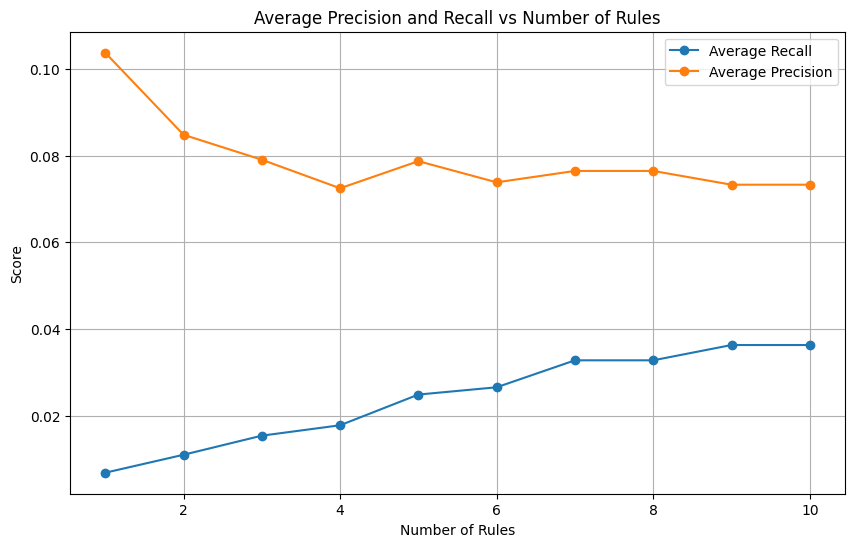

In [48]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), avg_recalls, label='Average Recall', marker='o')
plt.plot(range(1, 11), avg_precisions, label='Average Precision', marker='o')
plt.xlabel('Number of Rules')
plt.ylabel('Score')
plt.title('Average Precision and Recall vs Number of Rules')
plt.legend()
plt.grid(True)
plt.show()

**Observation and Analysis**

As we can see, the precision is highest at the first rule but decreases steadily as the number of rules increases while the recall increases gradually with the number of rules. This happens because as you add more rules, the likelihood of generating non-relevant recommendations increases. The system becomes more "inclusive," but many of the new recommendations might not be as relevant, thus lowering precision. The recall score rises because with more rules, the system is capturing more relevant items (even if it also adds non-relevant ones).

The trade-off between precision and recall is a common behavior in recommendation systems: adding more rules increases coverage (recall) but decreases the relevance of the recommendations (precision).

### 4. Take a sample example of users and their movie ratings from the test set and display precision and recall graphs.

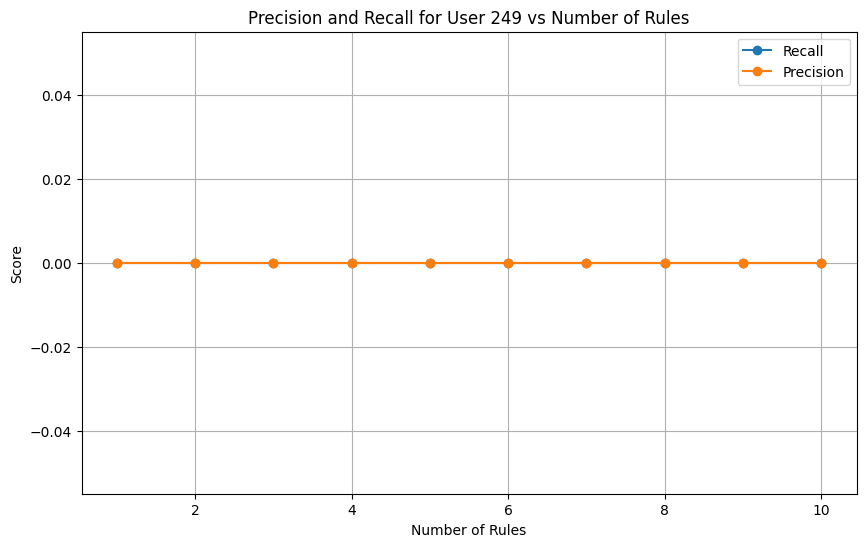

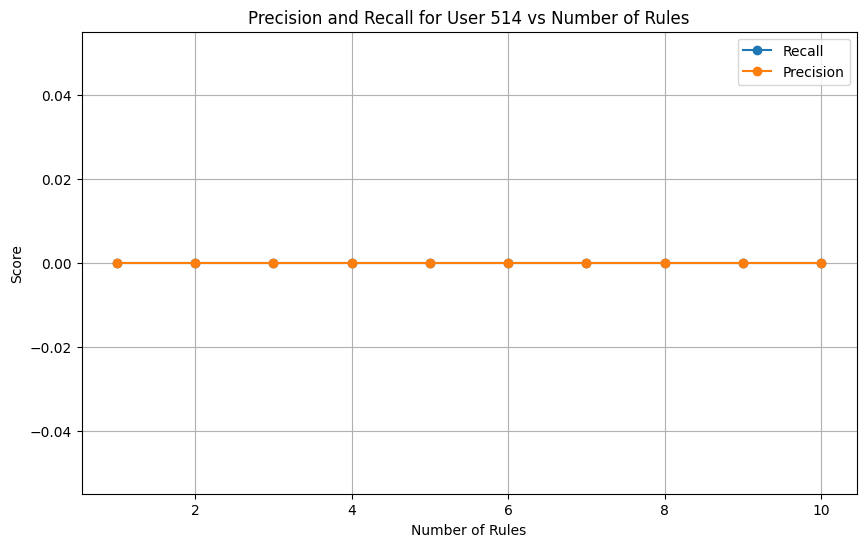

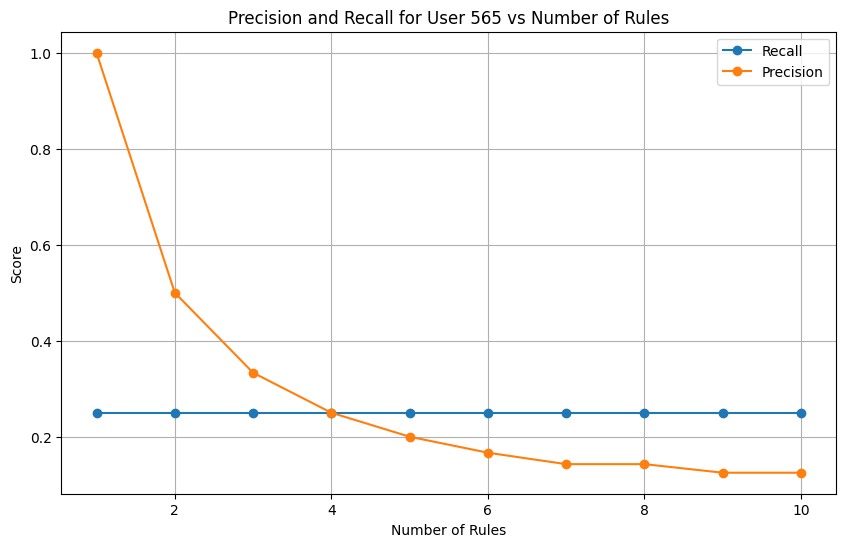

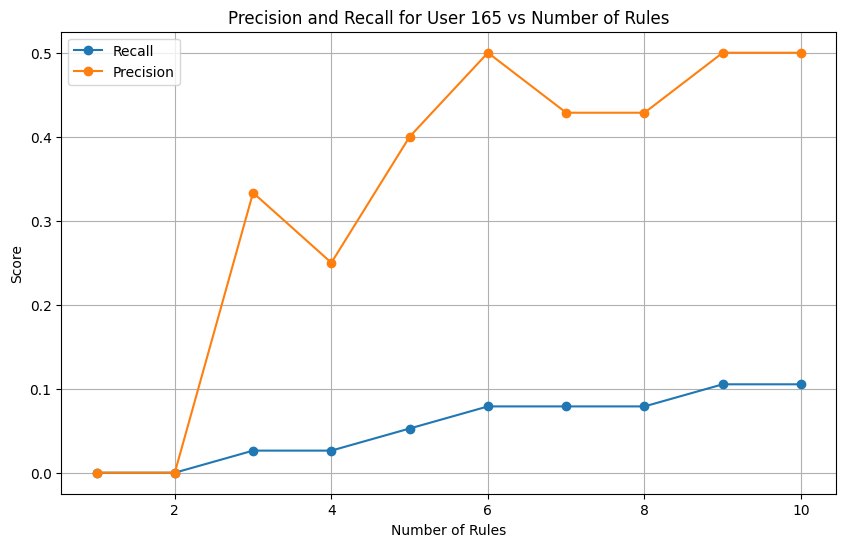

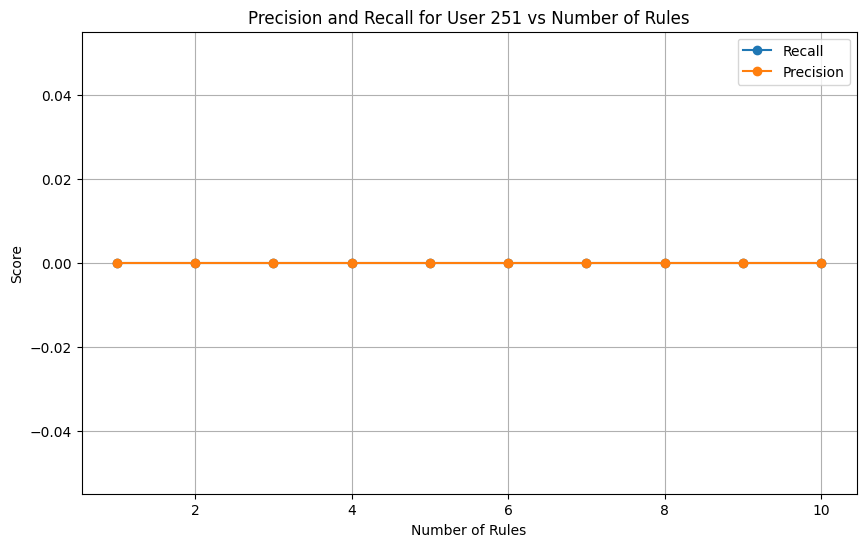

In [49]:
import random

random.seed(51)
random_users = random.sample(range(len(test_df)), 5)

for user in random_users:
    user_data = set(train_df.iloc[user]['movieId'])
    user_test = set(test_df.iloc[user]['movieId'])
    
    avg_recalls = []
    avg_precisions = []
    
    for i in range(1, 11):
        recom_set = set()
        user_transactions = [user_data]

        for rule in global_rules[:i]:
            antecedent, consequent, confidence, support = rule
            recom_set = recom_set.union(consequent)
        
        hit = recom_set.intersection(user_test)
        recall = len(hit) / len(user_test) if user_test else 0
        avg_recalls.append(recall)
        
        if len(recom_set) == 0:
            precision = 0
        else:
            precision = len(hit) / len(recom_set)
        avg_precisions.append(precision)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), avg_recalls, label='Recall', marker='o')
    plt.plot(range(1, 11), avg_precisions, label='Precision', marker='o')
    plt.xlabel('Number of Rules')
    plt.ylabel('Score')
    plt.title(f'Precision and Recall for User {user} vs Number of Rules')
    plt.legend()
    plt.grid(True)
    plt.show()

    


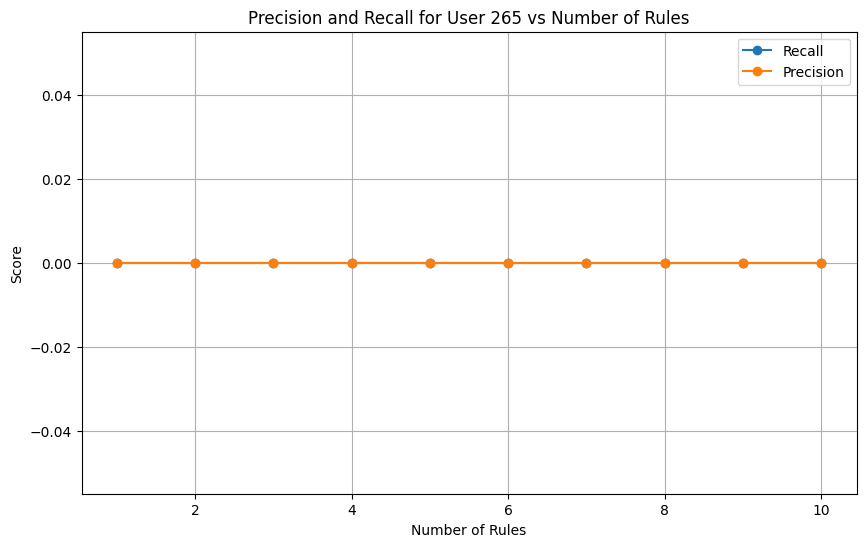

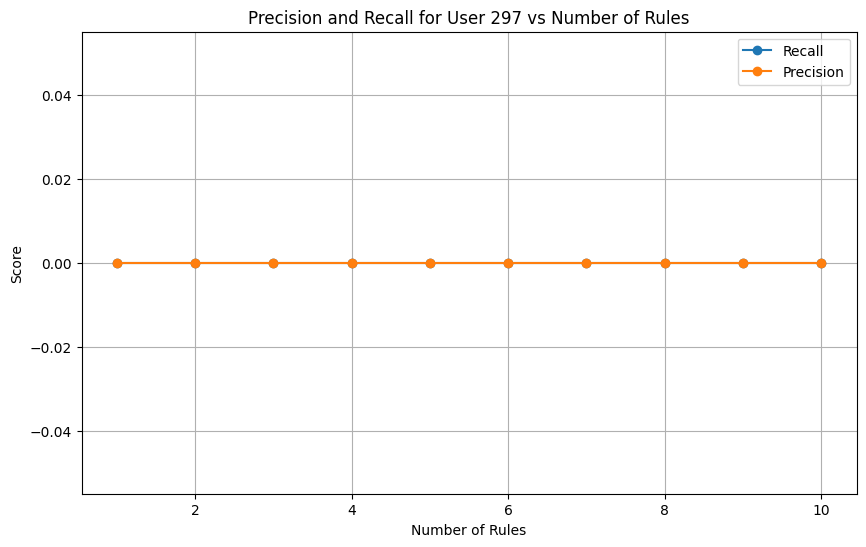

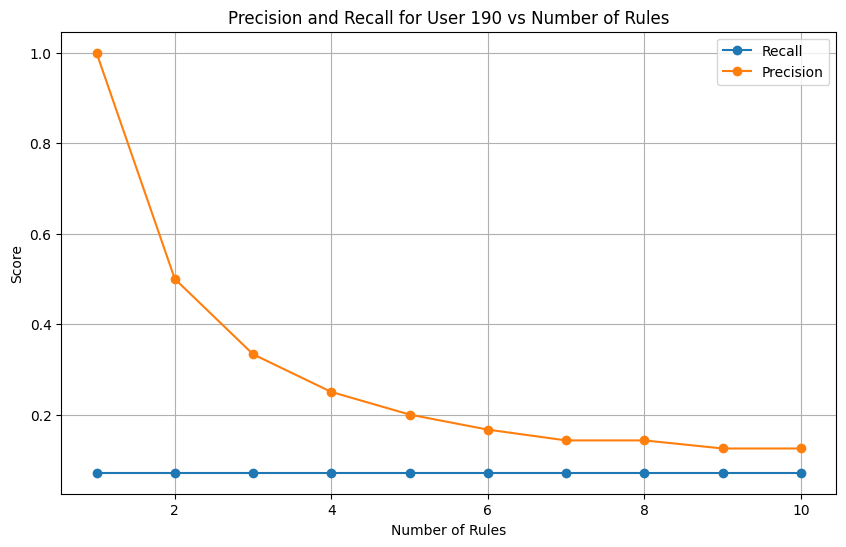

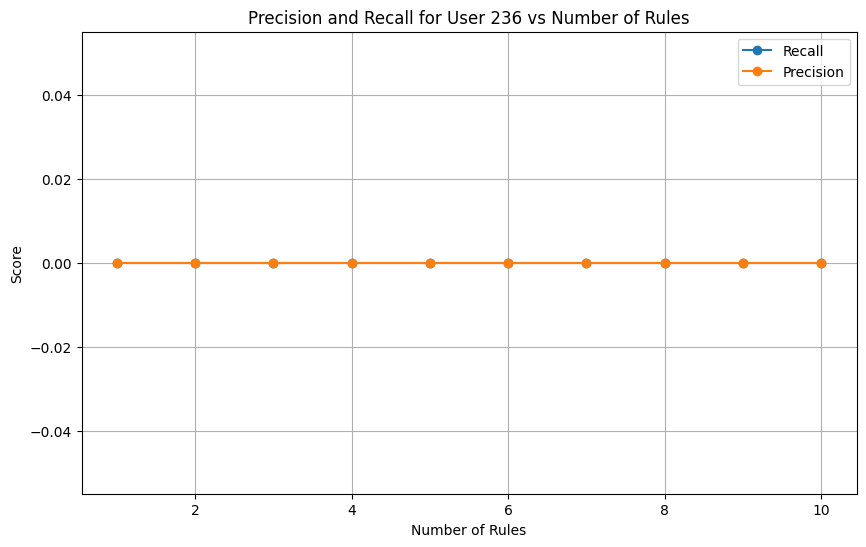

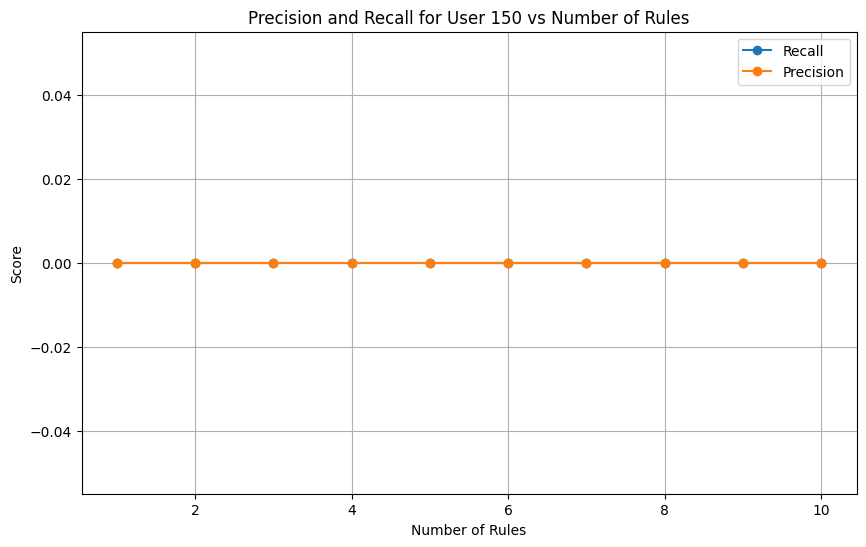

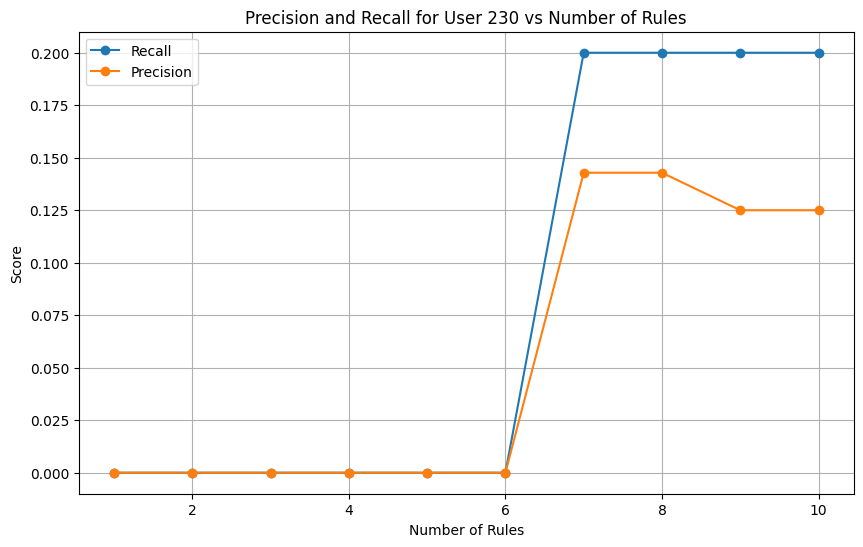

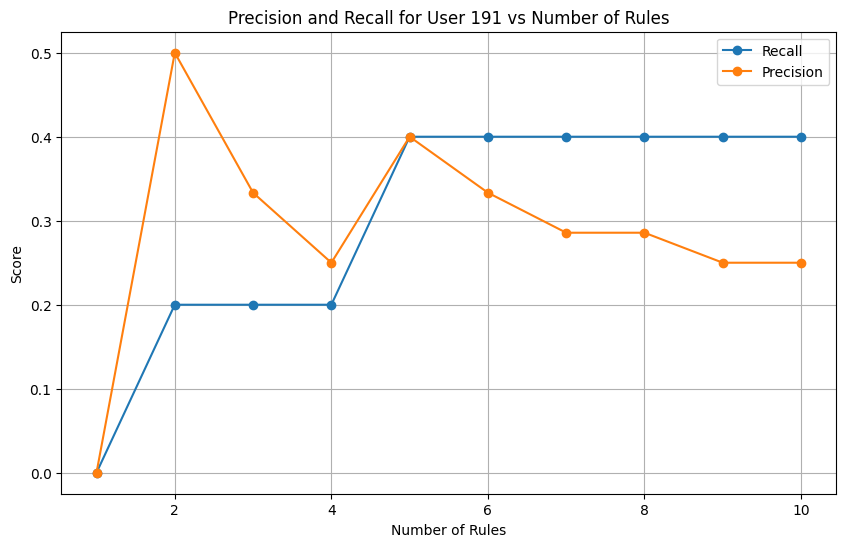

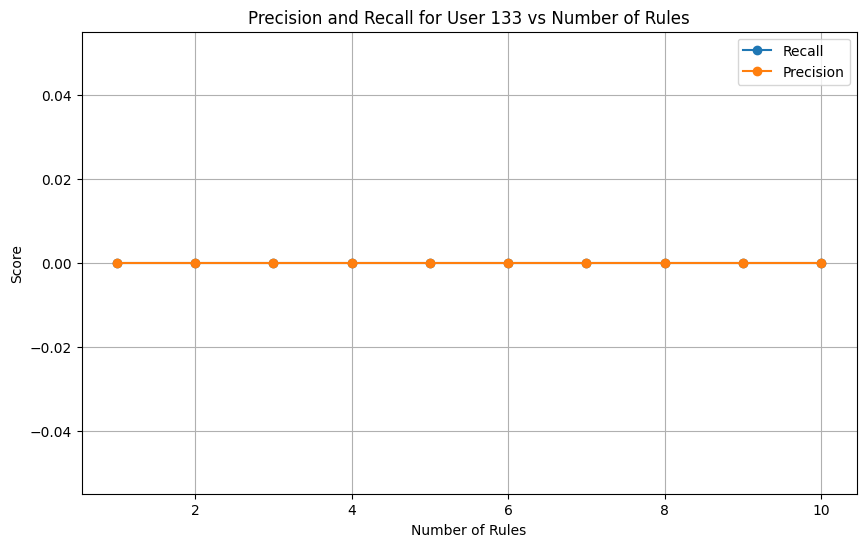

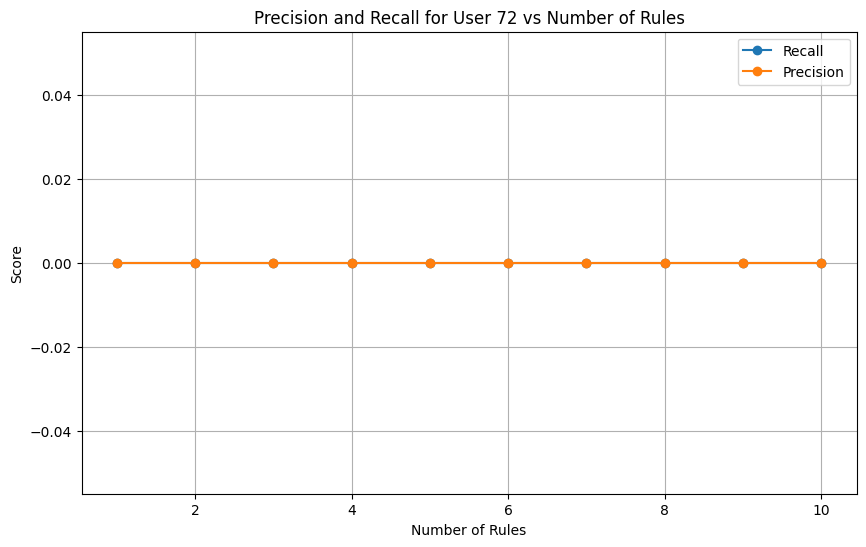

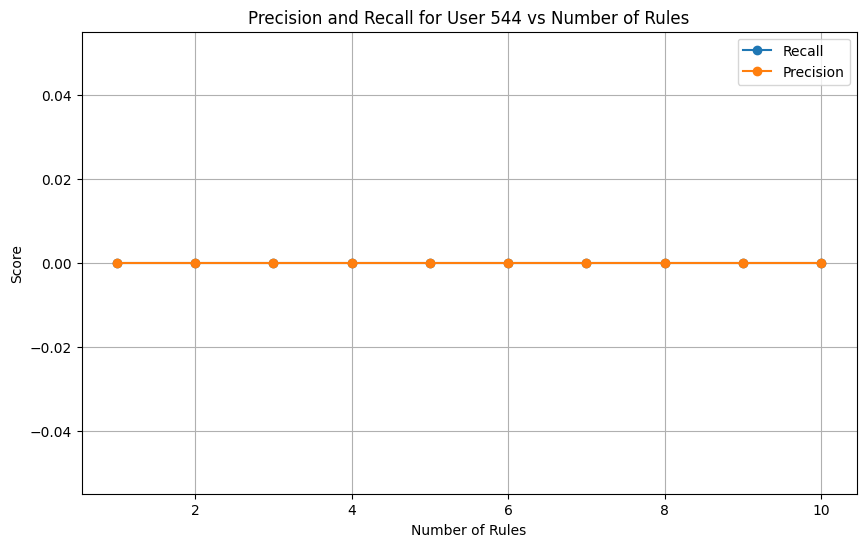

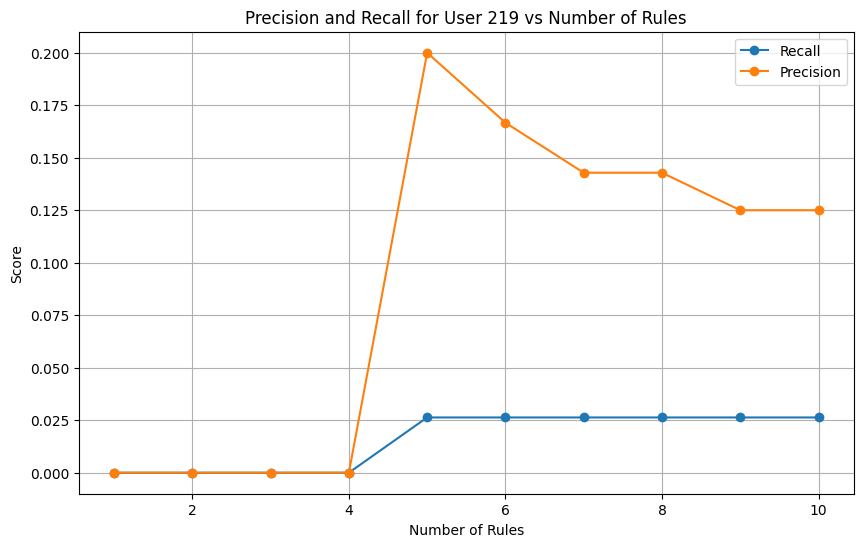

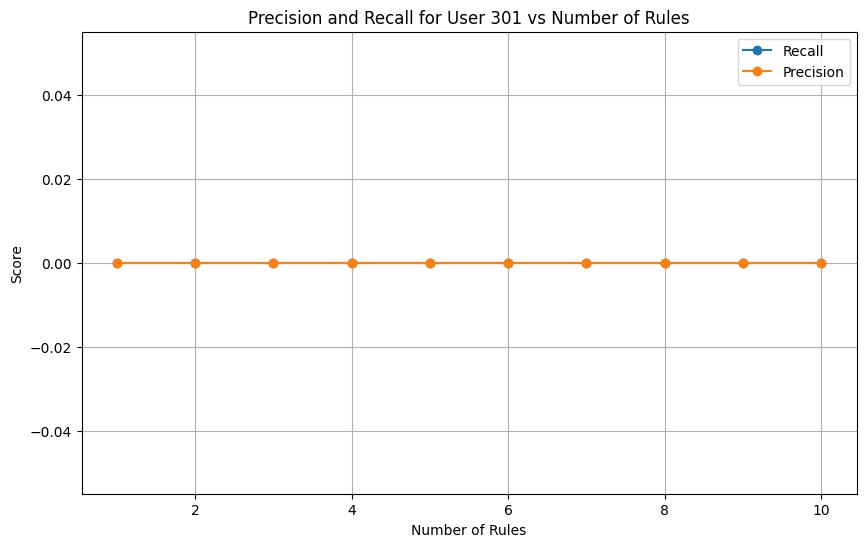

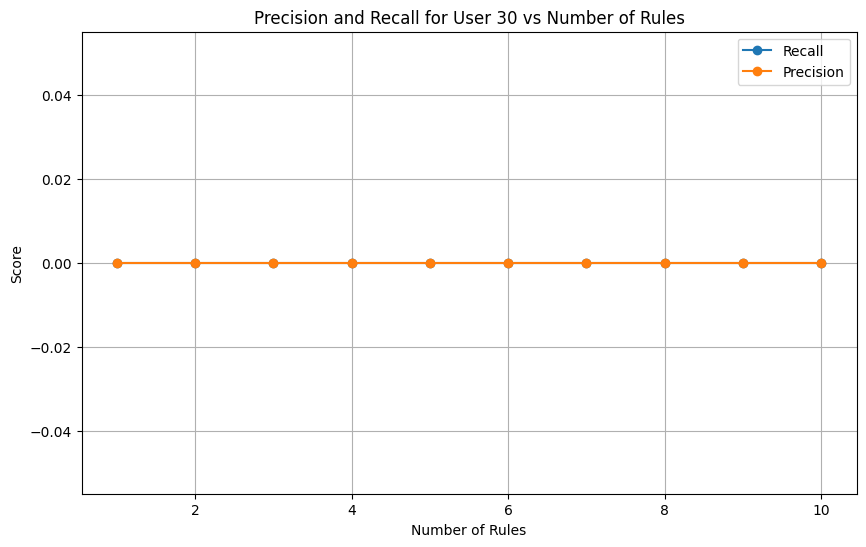

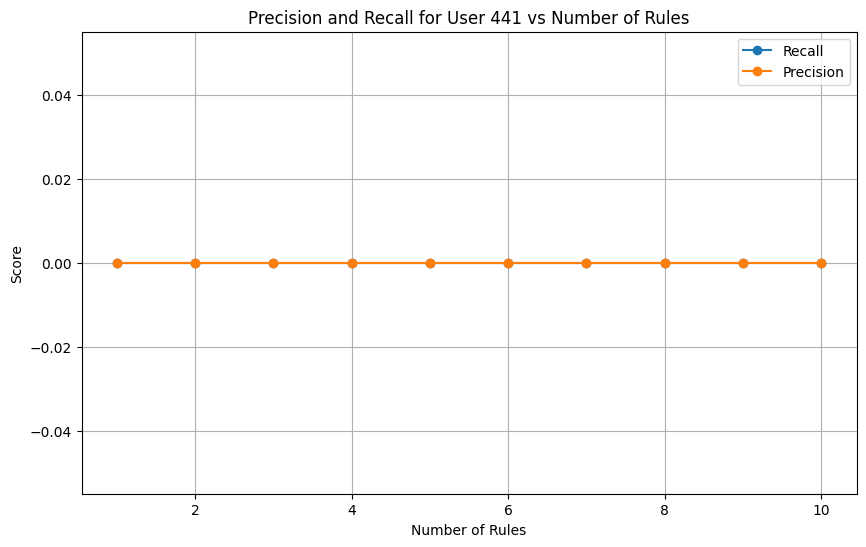

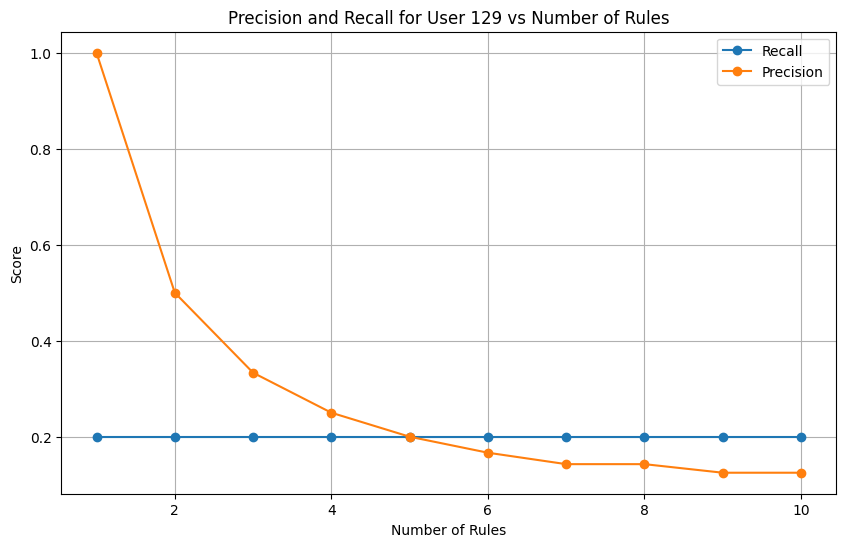

In [50]:
import random

random.seed(13)
random_users = random.sample(range(len(test_df)), 15)

for user in random_users:
    user_data = set(train_df.iloc[user]['movieId'])
    user_test = set(test_df.iloc[user]['movieId'])
    
    avg_recalls = []
    avg_precisions = []
    
    for i in range(1, 11):
        recom_set = set()
        user_transactions = [user_data]

        for rule in global_rules[:i]:
            antecedent, consequent, confidence, support = rule
            recom_set = recom_set.union(consequent)
        
        hit = recom_set.intersection(user_test)
        recall = len(hit) / len(user_test) if user_test else 0
        avg_recalls.append(recall)
        
        if len(recom_set) == 0:
            precision = 0
        else:
            precision = len(hit) / len(recom_set)
        avg_precisions.append(precision)
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, 11), avg_recalls, label='Recall', marker='o')
    plt.plot(range(1, 11), avg_precisions, label='Precision', marker='o')
    plt.xlabel('Number of Rules')
    plt.ylabel('Score')
    plt.title(f'Precision and Recall for User {user} vs Number of Rules')
    plt.legend()
    plt.grid(True)
    plt.show()

    


### 5. Include the plots in the Report (`md` or `pdf`) along with your justification of selection of your algorithm and also briefly explain how you built the entire recommendation system in the report.

`report.pdf` contains the report.

---